# Presentation of the OpenBHB dataset


This notebook introduces the [OpenBHB dataset](https://www.sciencedirect.com/science/article/pii/S1053811922007522), a large-scale, multi-site brain MRI dataset. It is designed to support benchmarking of machine learning and deep learning models in neuroimaging.

We will demonstrate how to use OpenBHB for two important prediction tasks:

- **Age prediction**
- **Sex classification**

These serve as simple entry points for evaluating model performance and potential bias across imaging sites.

> 📖 **Reference**:  
> Dufumier et al., *OpenBHB: a Large-Scale Multi-Site Brain MRI Dataset for Age Prediction and Debiasing*, NeuroImage, 2022.  
> [Read the paper](https://www.sciencedirect.com/science/article/pii/S1053811922007522)

## Install and load the packages

First, we need to install some Python packages required to run this notebook:

In [ ]:
%pip install -e ../
%pip install nilearn

In [30]:
import matplotlib.pyplot as plt
import nibabel
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import datasets, plotting
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    r2_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from nidl.datasets import OpenBHB


## Load the OpenBHB data and plot the modalities

OpenBHB contains 6 modalities (or preprocessed data) of healthy subject anatomical brains. It contains $n_{train}=3227$ training images for $n_{val}=757$ validation images. Demographic information about the subjects (age, sex) are available along with the acquisition machines (magnetic field strenght, acquisition setting). 

In [2]:
dataset = OpenBHB(root="/tmp/openBHB",
             modality=(
                 "vbm", "quasiraw", "vbm_roi", "fs_desikan_roi",
                 "fs_destrieux_roi", "fs_xhemi"),
             target=["age", "sex", "site"]
             )

### Plot whole-brain Voxel-Based Morphometry (VBM) and Quasi-Raw images

Let's take a look at the first subject in the dataset. We'll visualize two different modalities:

- **VBM** (Voxel-Based Morphometry): gray matter density maps computed using the CAT12 toolbox. VBM preprocessing involves tissue segmentation, normalization to MNI space, and modulation, resulting in voxel-wise maps that reflect local gray matter volume.

- **Quasi-Raw**: T1-weighted MRI scans that have been preprocessed with basic steps like bias correction and skull stripping, but without spatial normalization or heavy smoothing. The goal is to retain as much of the anatomical detail of the original scan as possible, providing input that is close to raw data while still being in the same physical space across subjects.


These visualizations help us understand what the model will receive as input.

(121, 145, 121)


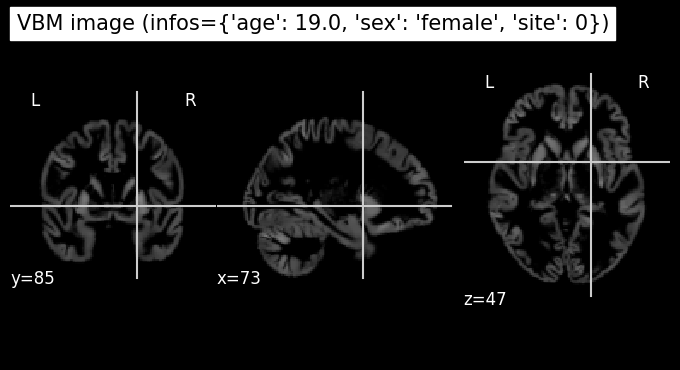

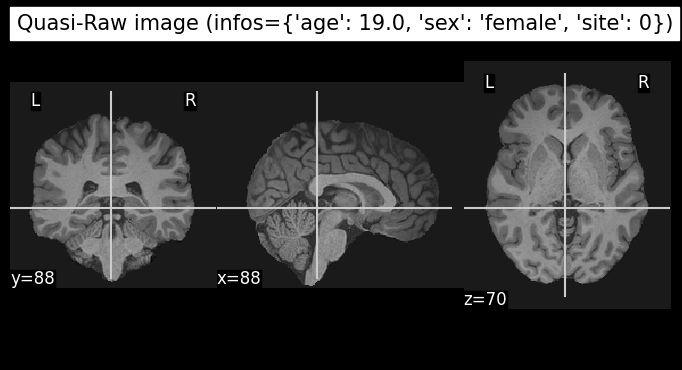

In [3]:
all_mods, infos = dataset[0]  # Get data from first subject

# VBM
img_vbm = all_mods["vbm"][0]  # select the first (and only) channel
nii_img = nibabel.Nifti1Image(img_vbm, affine=np.eye(4))
print(img_vbm.shape)
plotting.plot_anat(nii_img, title=f"VBM image (infos={infos})")

# Quasi-Raw
img_quasiraw = all_mods["quasiraw"][0]  # select the first (and only) channel
nii_img = nibabel.Nifti1Image(img_quasiraw, affine=np.eye(4))
plotting.plot_anat(nii_img, title=f"Quasi-Raw image (infos={infos})")

### Plot VBM-ROI on the Neuromorphometrics atlas

In this visualization, we map **regional gray matter volumes (VBM-ROI)** onto a brain template using the **[Neuromorphometrics atlas](https://neuro-jena.github.io/cat12-help/#Neuromorphometrics)**.

- The VBM-ROI features are computed by averaging voxel-wise gray matter volumes within each of the **142 anatomical regions** defined in the atlas.
- Each region corresponds to a gray matter structure, and volumes are extracted independently for each hemisphere.
- The resulting brain map shows the **regional gray matter volume in milliliters (mL)**.

In [4]:
def map_roi_on_neuromorphometrics_atlas(roi_values, labels, atlas):
    # Map ROI values on the Neuromorphometrics atlas
    atlas_data = atlas["data"].get_fdata()
    atlas_labels = atlas["labels"]
    brain_map = np.zeros_like(atlas_data)
    idx_mapping = {name: atlas_labels.index(name) for name in labels}
    for idx, label in enumerate(labels):
        brain_map[atlas_data == idx_mapping[label]] = roi_values[idx]
    brain_map = nibabel.Nifti1Image(brain_map, affine=atlas["data"].affine)
    return brain_map

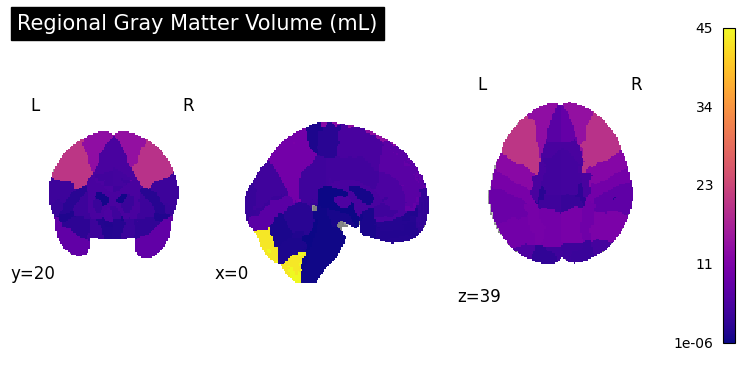

In [5]:
# Step 1: Select regional gray matter volumes for the first subject
# first 142 ROI volumes (gray matter only)
vbm_roi = all_mods["vbm_roi"][0][:142]

# Step 2: Clean up ROI labels (remove '_GM_Vol' suffix)
labels = [label.replace("_GM_Vol", "") for label in
          dataset.get_vbm_roi_labels()[:142]]

# Step 3: Load the Neuromorphometrics atlas used for mapping
atlas = dataset.get_neuromorphometrics_atlas()

# Step 4: Project the ROI values onto the brain volume using the atlas
brain_map = map_roi_on_neuromorphometrics_atlas(vbm_roi, labels, atlas)

# Step 5: Plot the resulting brain map
plotting.plot_stat_map(
    brain_map,
    title="Regional Gray Matter Volume (mL)",
    cmap="plasma",  # visually appealing sequential colormap
    draw_cross=False,
    colorbar=True,
)

### Plot Surface-Based Measures from FreeSurfer

The OpenBHB dataset includes **surface-based cortical measurements** extracted using FreeSurfer, such as:

- **Cortical thickness**
- **Surface area**
- **Gray matter volume**
- **Curvature**

These measures are averaged over predefined regions from:

- The **Desikan-Killiany atlas** (34 cortical regions per hemisphere)
- The **Destrieux atlas** (74 cortical regions per hemisphere, excluding the medial wall)

Each value represents a regional summary of the surface geometry or morphology of the cortex.

In addition, OpenBHB provides **xhemi** (cross-hemisphere) data computed on the fsaverage7 template (163842 vertices), which merges homologous regions across both hemispheres. This allows for analysis that reduces hemispheric asymmetries and improves statistical power by combining left and right hemisphere information.

In the following, we’ll define a small utility function to map these regional values onto the standard FreeSurfer surface (fsaverage5) for visualization of Desikan and Destrieux-based measures. For the xhemi data, which is computed on the higher-resolution fsaverage7 surface, visualization can be done similarly but requires using the corresponding fsaverage7 mesh files.

#### Visualize regional measures on the Destrieux atlas

In [6]:
def map_freesurfer_destrieux_data(roi_values, labels, hemi="left"):
    # Load Destrieux atlas
    fsaverage = datasets.fetch_atlas_surf_destrieux(verbose=0)
    fs_labels = [label.decode("utf-8") for label in fsaverage['labels']]
    map_hemi = fsaverage[f'map_{hemi}']
    
    # Map ROI values to vertex-wise data using the labels
    idx_mapping = {name: fs_labels.index(name) for name in labels}
    vertex_data = np.zeros_like(map_hemi, dtype=float)

    for idx, roi_name in enumerate(labels):
        vertex_data[map_hemi == idx_mapping[roi_name]] = roi_values[idx]

    return vertex_data

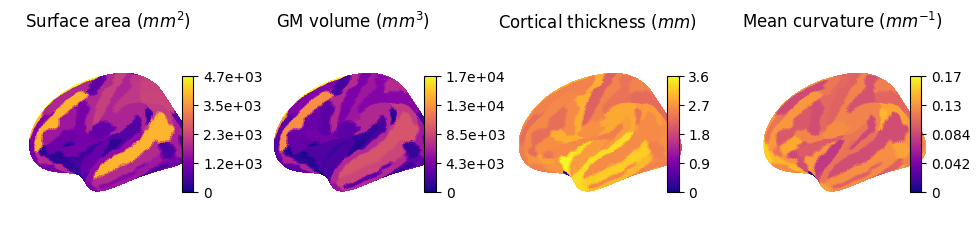

In [7]:
# Load the correct channel index for the features
surface_area = dataset.get_fs_roi_feature_names().index("surface_area_mm^2")
volume = dataset.get_fs_roi_feature_names().index("gray_matter_volume_mm^3")
thickness = dataset.get_fs_roi_feature_names().index("average_thickness_mm")
curvature = dataset.get_fs_roi_feature_names().index(
    "integrated_rectified_mean_curvature_mm^-1")
# Load the ROI data
labels = dataset.get_fs_labels(symmetric=True)
fs_surface = all_mods["fs_destrieux_roi"][surface_area]
fs_volume = all_mods["fs_destrieux_roi"][volume]
fs_thickness = all_mods["fs_destrieux_roi"][thickness]
fs_curv = all_mods["fs_destrieux_roi"][curvature]
# Map the ROI on the Destrieux surfacic atlas
surface_vertex = map_freesurfer_destrieux_data(fs_surface, labels)
volume_vertex = map_freesurfer_destrieux_data(fs_volume, labels)
thickness_vertex = map_freesurfer_destrieux_data(fs_thickness, labels)
curv_vertex = map_freesurfer_destrieux_data(fs_curv, labels)

# Prepare plots
data = [surface_vertex, volume_vertex, thickness_vertex, curv_vertex]
titles = [
    "Surface area ($mm^2$)",
    "GM volume ($mm^3$)",
    "Cortical thickness ($mm$)",
    "Mean curvature ($mm^{-1}$)"
]

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")
inflated_left = fsaverage['infl_left']
sulc_left = fsaverage['sulc_left']
fig, axes = plt.subplots(1, 4, figsize=(12, 3),
                         subplot_kw={'projection': '3d'})
# Plot each measurement
for ax, dat, title in zip(axes, data, titles):
    plotting.plot_surf(
        inflated_left,
        surf_map=dat,
        hemi='left',
        view='lateral',
        bg_map=sulc_left,
        cmap='plasma',
        colorbar=True,
        axes=ax,
        title=title,
        figure=fig
    )

plt.subplots_adjust(wspace=0.25)
plt.show()

#### Visualize vertex-wise measures on the fsaverage7 template

This example shows how to visualize several FreeSurfer surface features for the left hemisphere:

- `lh.curv`: Mean curvature map of the cortical surface, reflecting folding patterns (arbitrary unit, negative=sulci, positive=gyri).
- `lh.sulc`: Sulcal depth map, indicating the depth of sulci (cortical folds), in millimiter.
- `lh.thickness`: Cortical thickness values at each vertex (in millimiter).

We visualize these data on the `fsaverage7` template surface to better understand cortical morphology and anatomy.


[get_dataset_dir] Dataset found in /home/bd261576/nilearn_data/fsaverage

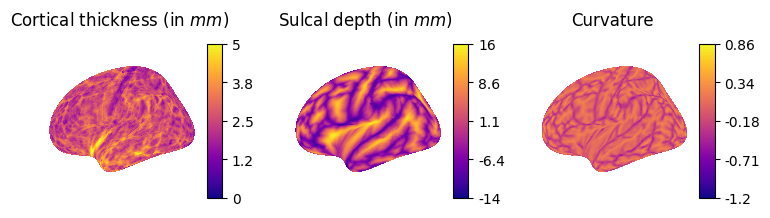

In [12]:
# Load the correct channels for xhemi
thickness = dataset.get_fs_xhemi_feature_names().index("lh.thickness")
sulc = dataset.get_fs_xhemi_feature_names().index("lh.sulc")
curv = dataset.get_fs_xhemi_feature_names().index("lh.curv")
# Load the xhemi data
fs_thickness = all_mods["fs_xhemi"][thickness]
fs_sulc = all_mods["fs_xhemi"][sulc]
fs_curv = all_mods["fs_xhemi"][curv]
# Get fsaverage7 template
fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage7")
infl_left = fsaverage['infl_left']
sulc_left = fsaverage['sulc_left']

# Prepare plots
data = [fs_thickness, fs_sulc, fs_curv]
titles = [
    "Cortical thickness (in $mm$)",
    "Sulcal depth (in $mm$)",
    "Curvature",
]
fig, axes = plt.subplots(1, 3, figsize=(9, 4), subplot_kw={'projection': '3d'})

for ax, dat, title in zip(axes, data, titles):
    plotting.plot_surf(
        infl_left,
        surf_map=dat,
        hemi='left', 
        bg_map=sulc_left,
        darkness=.5,
        cmap='plasma',
        colorbar=True,
        axes=ax,
        title=title,
        figure=fig)


## Fit ML and DL models for age and sex prediction

### Predicting age and sex with linear models

We demonstrate how to load the OpenBHB dataset and benchmark basic machine learning models on two standard tasks:

- **Age prediction** (regression)
- **Sex classification** (binary classification)

We will use a simple VBM-ROI representation (Gray Matter volumes extracted from CAT12) as features.

### Load the data

In [ ]:
# Load OpenBHB (train+val) with only VBM-ROI data
dataset_train = OpenBHB(
    "/tmp/openBHB",
    modality="vbm_roi",
    target=["age", "sex"],
    split="train",
    streaming=False
)
dataset_val = OpenBHB(
    "/tmp/openBHB",
    modality="vbm_roi",
    target=["age", "sex"],
    split="val",
    streaming=False
)

In [17]:
def extract_features_and_targets(dataset):
    X = []
    y_age = []
    y_sex = []

    for x, y in dataset:
        X.append(x.squeeze())  # shape (n_features,)
        y_age.append(y["age"])
        y_sex.append(y["sex"])

    return np.array(X), np.array(y_age), np.array(y_sex)

In [22]:
X_train, y_train_age, y_train_sex = extract_features_and_targets(dataset_train)
X_test, y_test_age, y_test_sex = extract_features_and_targets(dataset_val)
print("Shape of (X_train, X_test):", (X_train.shape, X_test.shape))
print("Age range:", y_train_age.min(), "-", y_train_age.max())
print("Sex distribution:\n", pd.Series(y_train_sex).value_counts())

Shape of (X_train, X_test): ((3227, 284), (757, 284))
Age range: 6.0 - 86.19849418206707
Sex distribution:
 male      1669
female    1558
Name: count, dtype: int64


### 1) Age prediction with Ridge regression

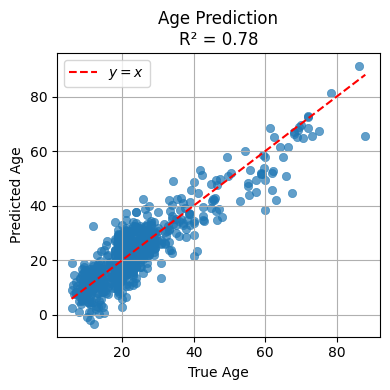

In [34]:
# Define model pipeline
ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))

# Fit the model
model_age = ridge.fit(X_train, y_train_age)

# Predict on test set
y_pred_age = model_age.predict(X_test)

# Scatter plot
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test_age, y=y_pred_age, alpha=0.7, edgecolor=None)
sns.lineplot(x=y_test_age, y=y_test_age, color='red',
             linestyle='--', label='$y=x$')

# Add labels and R² score
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title(
    f"Age Prediction\nR² = {r2_score(y_test_age, y_pred_age):.2f}"
)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 2) Sex classification with logistic regression

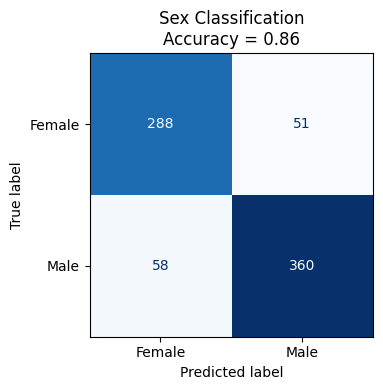

In [35]:
# Define model pipeline
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Fit the model
model_sex = logreg.fit(X_train, y_train_sex)

# Predict on test set
y_pred_sex = model_sex.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test_sex, y_pred_sex)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Female", "Male"])

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(
        "Sex Classification\n"
        f"Accuracy = {accuracy_score(y_test_sex, y_pred_sex):.2f}"
)

plt.grid(False)
plt.tight_layout()
plt.show()